<a href="https://colab.research.google.com/github/sidhant-guliani/satellite-images-CNN/blob/master/cnn_geospatial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import gc
import zipfile
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, ReLU, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import cv2
from tqdm import tqdm
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

local_zip = '/content/drive/My Drive/Colab_Notebooks/503255_938046_compressed_planet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/amazon_data')
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [71]:
!ls ../amazon_data/planet

sample_submission.csv  test-jpg  train_classes.csv  train-jpg


In [4]:
base_dir = '../amazon_data/planet'
train_v2_file= os.path.join(base_dir, 'train_classes.csv')
submission_path = os.path.join(base_dir, 'sample_submission.csv')

df_train_data = pd.read_csv(train_v2_file)
df_test = pd.read_csv(submission_path)
#df_test = df_test[~df_test.image_name.str.startswith('test')]


In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train_data['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [6]:
valid_data_size = 5000
input_size = 32
input_channels = 3
filters = 64

epochs = 15
batch_size = 128
learning_rate = 0.001
lr_decay = 1e-4
valid_data_size = 5000

In [7]:
x_valid = []
y_valid = []

df_valid = df_train_data[(len(df_train_data) - valid_data_size):]
for f, tags in tqdm(df_valid.values, miniters=500):
    dir_open= os.path.join(base_dir, 'train-jpg/{}.jpg'.format(f))
    img = cv2.imread(dir_open)
    img = cv2.resize(img, (input_size, input_size))

    targets = np.zeros(17)
    
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_valid.append(img)
    y_valid.append(targets)

y_valid = np.array(y_valid, np.uint8)
x_valid = np.array(x_valid, np.float32)

100%|██████████| 5000/5000 [00:07<00:00, 685.81it/s]


In [8]:
print(x_valid.shape)
print(y_valid.shape)

(5000, 32, 32, 3)
(5000, 17)


In [9]:
x_train = []
y_train = []

df_train = df_train_data[:(len(df_train_data) - valid_data_size)]

for f, tags in tqdm(df_train.values, miniters=10000):
    dir_open= os.path.join(base_dir, 'train-jpg/{}.jpg'.format(f))
    img = cv2.imread(dir_open)
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)

    for t in tags.split(' '):
        targets[label_map[t]] = 1

    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 0)  # flip vertically
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 1)  # flip horizontally
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 0)  # flip vertically
    x_train.append(img)
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

100%|██████████| 35479/35479 [00:50<00:00, 702.71it/s]


In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))
model.add(Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
              
history_1 = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_valid, y_valid))

accuracy = history_1.history['accuracy']
val_loss = history_1.history['val_loss']
loss = history_1.history['loss']
val_acc = history_1.history['val_accuracy']

epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/20
1109/1109 [==============================] - 613s 553ms/step - loss: 0.1771 - accuracy: 0.4121 - val_loss: 0.1397 - val_accuracy: 0.4152
Epoch 2/20
1109/1109 [==============================] - 614s 553ms/step - loss: 0.1354 - accuracy: 0.4363 - val_loss: 0.1231 - val_accuracy: 0.4472
Epoch 3/20
1000/1109 [==========================>...] - ETA: 59s - loss: 0.1271 - accuracy: 0.4391 

In [12]:
history_dict = history_1.history
print(history_dict.keys())

'''mae_history.append(history.history['mean_absolute_error'])
mae_history_val.append(history.history['val_mean_absolute_error'])
loss.append(history.history['loss'])
loss_val.append(history.history['val_loss'])'''

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


"mae_history.append(history.history['mean_absolute_error'])\nmae_history_val.append(history.history['val_mean_absolute_error'])\nloss.append(history.history['loss'])\nloss_val.append(history.history['val_loss'])"

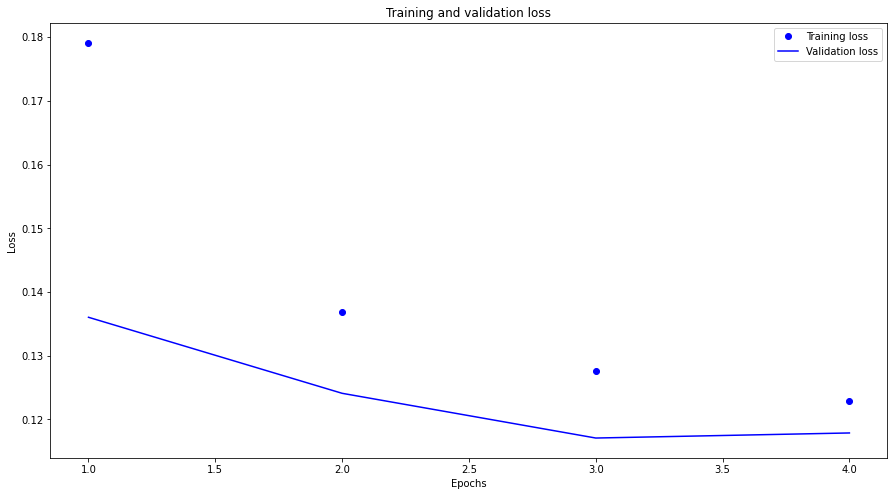

In [16]:
accuracy = history_1.history['accuracy']
val_loss = history_1.history['val_loss']
loss = history_1.history['loss']
val_acc = history_1.history['val_accuracy']

epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

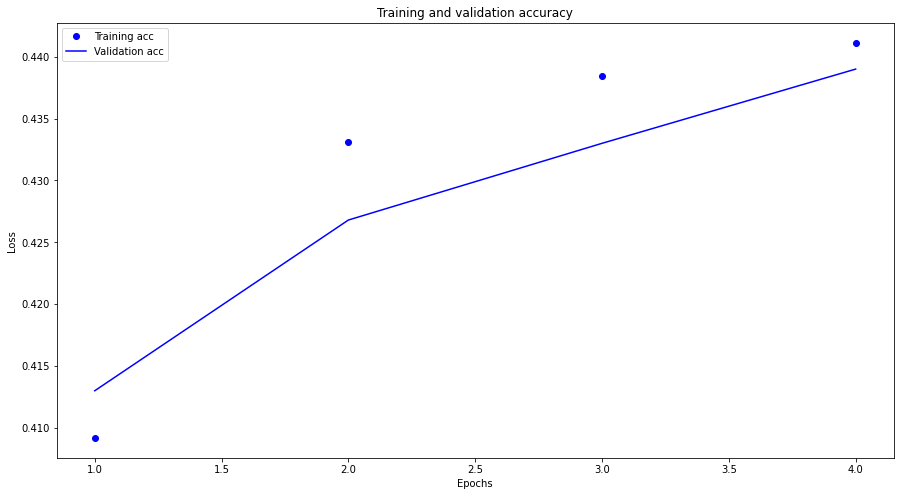

In [17]:
plt.figure(figsize=(15,8))
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# in this cell Im not using the kfold validation and fit_generator (using fit)
model = Sequential()
model.add(Conv2D(filters, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(input_size, input_size, 3)))

model.add(Conv2D(filters, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(x_valid, y_valid))
          

Epoch 1/4
 724/1109 [==================>...........] - ETA: 4:28 - loss: 0.3159 - accuracy: 0.0559

In [ ]:
x#https://www.kaggle.com/petrosgk/1st-try-with-keras-0-918-lb

In [ ]:
x_test = []

for f, tags in tqdm(df_test.values, miniters=1000):
    dir_open= os.path.join(base_dir, 'test-jpg/{}.jpg'.format(f))
    img = cv2.imread(dir_open)
    if type(img) is np.ndarray:
      if img.size == 0:
        continue
    if img is None:
        continue
    img = cv2.resize(img, (input_size, input_size))
    x_test.append(img)

x_test = np.array(x_test, np.float32)

In [67]:
y_test = []
p_test = model.predict(x_test, batch_size=batch_size, verbose=2)
y_test.append(p_test)
result = np.array(y_test[0])
result = pd.DataFrame(result, columns=labels)
preds = []


318/318 - 20s


In [68]:
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.iloc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    preds.append(' '.join(list(a.index)))

#df_test['tags'] = preds





  0%|          | 0/40669 [00:00<?, ?it/s]



  2%|▏         | 1000/40669 [00:03<02:07, 311.16it/s]



  5%|▍         | 2000/40669 [00:06<02:04, 311.14it/s]



  7%|▋         | 3000/40669 [00:09<02:03, 305.60it/s]



 10%|▉         | 4000/40669 [00:13<02:00, 303.74it/s]



 12%|█▏        | 5000/40669 [00:16<02:00, 295.13it/s]



 15%|█▍        | 6000/40669 [00:20<02:00, 288.49it/s]



 17%|█▋        | 7000/40669 [00:23<01:54, 293.06it/s]



 20%|█▉        | 8000/40669 [00:27<01:50, 294.38it/s]



 22%|██▏       | 9000/40669 [00:30<01:49, 290.19it/s]



 25%|██▍       | 10000/40669 [00:34<01:45, 290.74it/s]



 27%|██▋       | 11000/40669 [00:37<01:40, 296.46it/s]



 30%|██▉       | 12000/40669 [00:40<01:36, 296.47it/s]



 32%|███▏      | 13000/40669 [00:44<01:34, 291.83it/s]



 34%|███▍      | 14000/40669 [00:47<01:29, 297.96it/s]



 37%|███▋      | 15000/40669 [00:50<01:27, 293.50it/s]



 39%|███▉      | 16000/40669 [00:54<01:25, 289.91it/s]



 42%|████▏     | 17000/40669 [00

NameError: ignored